<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202510_AML/blob/main/Laboratorios/Laboratorio_5/MINE_4206_202510_AML_Lab5_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

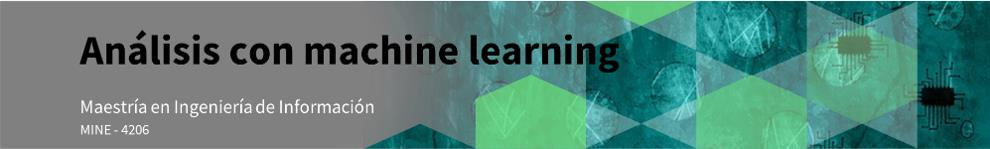

#Tabla de contenido

[Contexto y objetivos.](scrollTo=opGTmPf8s2Fw)<br>
[0. Instalación e importación de librerías.](#scrollTo=gjQDyeHN5Lib)<br>
[1. Introducción a los datos.](#scrollTo=6OKhZATq6Jlt)<br>
[3. Modelamiento.](#scrollTo=fy59XxXphe_L)<br>

---
# Contexto y objetivos.

Los accidentes cerebrovasculares (ACV), conocidos comúnmente como derrame cerebral, generan afectaciones o bloqueos en el flujo sanguíneo en el cerebro. Existen estudios que han relacionado distintas causas con los ACV, como el índice de masa corporal (BMI en inglés), la edad, entre otros. Con miras a realizar un proceso de detección temprana para esta enfermedad, se construirá un modelo  a partir de los datos relacionados con  pacientes sanos. Posteriormente, se evaluará la capacidad del modelo en la identificación de pacientes que hayan sufrido un derrame cerebral.

Para lograr este propósito construiremos un modelo que permita aprender de los pacientes sanos y sin presentar un derrame cerebral y posteriormente reconstruiremos combinando pacientes sin derrames (sanos) junto con pacientes que hayan sufrido un derrame.

**Objetivos:**

*   Resolver un problema de detección de anomalías.
*   Realizar el entrenamiento de una sola clase.
*   Analizar la Arquitectura de los AutoEncoders.

La fuente de los datos la puedes encontrar en [Cerebral Stroke Prediction](https://www.kaggle.com/datasets/shashwatwork/cerebral-stroke-predictionimbalaced-dataset).



Para tener un mejor detalle sobre el comportamiento de las variables, solicitamos a la organización el diccionario de datos y nos suministró la siguiente información:

| ATRIBUTO | DEFINICIÓN |
| :- | :- |
| **id** | Corresponde al identificador.|
| **gender** | Género del paciente.|
| **age** | Edad del paciente.|
| **hypertension** | Indica si el paciente sufre o no de hipertensión.|
| **heart_disease** | Indica si el paciente sufre de enfermedades del corazón.|
| **ever_married** | Registra si el usuario siempre ha estado casado.|
| **work_type** | Relaciona el tipo de trabajo del paciente.|
| **residence_type** | Indica el tipo de recidencia del paciente.|
| **avg_glucose_level** | Registra el nivel de glucosa.|
| **bmi** | Índice de masa corporal del paciente.|
| **smoking_status** | Información acerca de si el paciente fuma y la frecuencia.|
| **stroke** | Información acerca de ataques cerebrales.|

---
# 0. Instalación e importación de librerías

In [1]:
!pip install ydata-profiling -q
!pip install plotly -q
!pip install kaggle -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.0 MB/s eta 0:00:00


In [2]:
#Manejo de datos
import pandas as pd
import numpy as np

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go

#Analisis profundo de datos
from ydata_profiling import ProfileReport

#Tensorflow y keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.optimizers import Adam

#Entrenamiento del modelo
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import classification_report, confusion_matrix

#Librerías extras
import itertools

from datetime import datetime

print(f"La versión de sklearn es: {sklearn.__version__}")
print(f'La versión de Tensor Flow es:', tf.__version__)

La versión de sklearn es: 1.6.1
La versión de Tensor Flow es: 2.18.0


# 1. Introducción a los datos.

Parámetros generales y carga de la información.

In [3]:
#Porcentaje para validación y test
test_val_alpha = 0.2
#random_state o semilla para la reproducibilidad
my_seed = 19

Configuración del entorno de kaggle.

In [4]:
!ls -lha kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 70 Apr 30 23:02 kaggle.json


Una vez hemos asegurado la conectividad, procedemos a realizar el proceso de descarga de la información..

In [5]:
!kaggle datasets download shashwatwork/cerebral-stroke-predictionimbalaced-dataset

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/cerebral-stroke-predictionimbalaced-dataset
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)


In [6]:
ROOT_DIR = '/content'
DATASET_NAME = 'cerebral-stroke-predictionimbalaced-dataset'
DATASET_FILE = "dataset.csv"

In [7]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  cerebral-stroke-predictionimbalaced-dataset.zip
  inflating: /content/cerebral-stroke-predictionimbalaced-dataset/dataset.csv  


In [8]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/{DATASET_FILE}"
print(DATA_DIR)

/content/cerebral-stroke-predictionimbalaced-dataset/dataset.csv


In [9]:
data_df = pd.read_csv(DATA_DIR)

Generamos una previsualización de la información:

In [10]:
data_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Verificamos el número de instancias y características:

In [11]:
print(f"Dimensión: El número de instancias es: {data_df.shape[0]:,}, el número de características (features) es: {data_df.shape[1]}")

Dimensión: El número de instancias es: 43,400, el número de características (features) es: 12


Separación de la información.

Definimos la variable que permite identificar el comportamiento normal y el paciente enfermo:

In [12]:
target_feature = 'stroke'

In [13]:
categories = data_df[target_feature].tolist()

cat_freq = {category: categories.count(category) for category in set(categories)}
sort_categories = sorted(cat_freq.keys())
sort_freq = [cat_freq[categoria] for categoria in sort_categories]

fig = go.Figure(data=[go.Bar(x=sort_categories, y=sort_freq)])
fig.update_layout(title=f'Comportamiento de la variable {target_feature}', xaxis_title='Categoría', yaxis_title='Frecuencia')

fig.show()

Separamos los datos de entrenamiento y test (20%), junto con la semilla (`random_state`):

Sin embargo, debemos tener en cuenta que en el contexto de detección de anomalías, solo debemos enviar la información de la clase normal.

In [14]:
normal_df = data_df[data_df["stroke"] == 0]
disease_df = data_df[data_df["stroke"] == 1]
normal_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [15]:
train, test = train_test_split(normal_df, test_size=test_val_alpha, random_state=my_seed)
print("Resúmen de la información")
print(f"Clase normal: {train.shape[0]:,}")
print(f"Accidentes cerebrovasculares: {disease_df.shape[0]:,}")
print(f"Test total: {test.shape[0]:,}")

#Vamos a realizar las pruebas combinando los datos de prueba de la clase normal y a su vez los pacientes con enfermedad
test = pd.concat([test, disease_df])
train.head()

Resúmen de la información
Clase normal: 34,093
Accidentes cerebrovasculares: 783
Test total: 8,524


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
37105,70010,Female,39.0,0,0,Yes,Private,Urban,152.99,27.6,formerly smoked,0
25344,69420,Male,64.0,0,0,Yes,Self-employed,Urban,72.26,23.2,formerly smoked,0
11084,20241,Male,13.0,0,0,No,Private,Rural,72.30,21.0,never smoked,0
33531,61813,Female,68.0,0,0,Yes,Govt_job,Urban,143.18,27.6,formerly smoked,0
15315,38832,Male,23.0,0,0,No,Private,Rural,122.69,31.0,never smoked,0


Demos un vistazo al número de instancias para cada uno de los conjuntos de datos:

In [16]:
train_count = train.shape[0]
test_count = test.shape[0]

print("-------------------SEPARACIÓN DE LA INFORMACIÓN-------------------")
print(f"-> Train: {train_count:,}")
print(f"-> Test: {test_count:,}")

has_duplicates = (train[train.duplicated()].shape[0] == True)

-------------------SEPARACIÓN DE LA INFORMACIÓN-------------------
-> Train: 34,093
-> Test: 9,307


**Exploración de los datos.**

Los tipos de datos son los siguientes:

In [17]:
train.dtypes

,0
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64


In [20]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 14.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Insights obtenidos de la información.**

Los datos tienen un total de 12 variables o características, un total de 47.430 instancias. No tiene instancias (filas) duplicadas.

Los tipos de datos para las variables se distribuyen de la siguiente forma:
* 4 numéricas.
* 7 categóricas.
* 1 booleana (verdadero y falso).


Las recomendaciones de tratamiento de la información para cada una de las características, son las siguientes:

|ATRIBUTO | PROPUESTA |
|---| :- |
| **id** | Se recomienda eliminar esta característica.|
| **gender** | Cuenta con 3 categorías, 2 de ellas balanceadas y algunos valores para la categoría `Others`. No presenta ausencias.|
| **age** | Presenta un comportamiento similar a una distribución normal. No presenta ausencias.|
| **hypertension** | La clase no está balanceada, no obstante en el contexto de la organización el porcentaje de hipertensión no suele ser alto.|
| **heart_disease** | a clase no está balanceada, no obstante en el contexto de la organización el porcentaje de hipertensión no suele ser alto.|
| **ever_married** | Como es variable booleana, se debe realizar la transformación. No presenta ausencias.|
| **work_type** | Cuenta con 5 categorías. No presenta ausencias.|
| **residence_type** | La clase está balanceada. No presenta ausencias.|
| **avg_glucose_level** | Registra el nivel de glucosa.|
| **bmi** | Índice de masa corporal del paciente. 1.085 el cuál supera el 3% de los datos, presenta ausencias, se recomienda eliminar estos valores.|
| **smoking_status** | Presenta 3 categorías `never smoked`, `formerly smoked` y `smokes`. Pero cuenta con 10.503 ausencias, en este contexto de salud es mejor eliminar la variable debido a informacion sensible.|

**Preparación de la información.**

Normalizamos y estandarizamos los datos con la intención de buscar una mejor convergencia [normalizing your data](https://www.jeremyjordan.me/batch-normalization/).

Generamos una copia de los conjuntos de datos:

In [18]:
new_train_ = train.copy()
new_test_ = test.copy()

De acuerdo con todo el análisis exploratorio, procedemos en primera instancia a definir las características que serán eliminadas:

In [19]:
#Características a eliminar
drop_fields = ["id", "smoking_status"]

Definimos las columnas para las que serán eliminamos los valores ausentes:

In [20]:
#Columnas con ausencias por eliminar
missing_val_fields = ["bmi"]

Definimos las variables booleanas a transformar a valor numérico:

In [21]:
#Columnas con valores verdadero o falso que requieren transformación a número
bool_to_num_fields = ["ever_married"]

Generamos funciones para el borrado de las columnas y eliminación de valores ausentes:

In [22]:
#Función de borrado de features no usados
def drop_features(train_, test_, features):
  train_ = train.drop(features, axis=1)
  test_ = test_.drop(features, axis=1)

  return train_, test_

#Función de borrado de instancias (registros) con ausencias
def drop_missing_values(train_, test_, features):
  for feature in features:
    train_ = train_[train_[feature].isnull() == False]
    test_ = test_[test_[feature].isnull() == False]

  return train_, test_

In [23]:
#Ejecutamos las funciones de limpieza de la información
new_train_, new_test_ = drop_features(new_train_ , new_test_, drop_fields)
new_train_, new_test_ = drop_missing_values(new_train_, new_test_, missing_val_fields)

In [24]:
print(f"El número de características (features) ahora es: {new_train_.shape[1]}")

El número de características (features) ahora es: 10


Compilamos los nombres de las características numéricas en una sola variable:

In [25]:
num_fields = new_train_.select_dtypes(include=[np.number]).columns.tolist()
del num_fields[num_fields.index(target_feature)]
num_fields

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

Hacemos lo mismo con las variables categoricas:

In [26]:
cat_fields = ["gender", "Residence_type"]

---
# 3. Modelamiento.

##3.1. Preparación de los datos.

In [27]:
X_train, Y_train = new_train_.drop([target_feature], axis=1), new_train_[target_feature]
display(X_train)
display(Y_train)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi
37105,Female,39.0,0,0,Yes,Private,Urban,152.99,27.6
25344,Male,64.0,0,0,Yes,Self-employed,Urban,72.26,23.2
11084,Male,13.0,0,0,No,Private,Rural,72.30,21.0
33531,Female,68.0,0,0,Yes,Govt_job,Urban,143.18,27.6
15315,Male,23.0,0,0,No,Private,Rural,122.69,31.0
...,...,...,...,...,...,...,...,...,...
34422,Female,79.0,0,0,Yes,Private,Rural,125.27,32.9
21795,Female,77.0,1,0,Yes,Govt_job,Urban,192.87,30.7
34764,Female,12.0,0,0,No,children,Urban,79.06,26.7
17429,Male,53.0,0,0,Yes,Self-employed,Urban,86.54,31.8


,stroke
37105,0
25344,0
11084,0
33531,0
15315,0
...,...
34422,0
21795,0
34764,0
17429,0


In [28]:
X_test, Y_test = new_test_.drop([target_feature], axis=1), new_test_[target_feature]
display(X_test)
display(Y_test)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi
6974,Female,34.0,0,0,Yes,Private,Urban,56.98,32.2
36276,Female,14.0,0,0,No,children,Urban,63.95,24.9
28944,Male,11.0,0,0,No,children,Rural,78.83,20.5
12738,Female,14.0,0,0,No,Never_worked,Rural,94.69,22.6
2761,Female,34.0,0,0,Yes,Self-employed,Rural,78.12,32.0
...,...,...,...,...,...,...,...,...,...
43130,Female,82.0,0,1,Yes,Self-employed,Urban,118.61,29.4
43148,Female,56.0,0,0,Yes,Private,Rural,83.27,32.9
43268,Male,69.0,0,0,Yes,Self-employed,Rural,97.36,28.0
43304,Female,80.0,0,0,Yes,Self-employed,Urban,75.91,26.7


,stroke
6974,0
36276,0
28944,0
12738,0
2761,0
...,...
43130,1
43148,1
43268,1
43304,1


##3.2. Funciones y variables de apoyo.

In [29]:
def fix_num_values(df):
  for column in df.columns:
    #Conversión de valores booleanos a números
    if np.isin(column, bool_to_num_fields) == True:
      df[column] = df[column].astype(bool)
      df[column] = df[column].map({True: 1, False: 0})

  return df

In [30]:
def fix_cat_values(df):
  for column in df.columns:
    df[column] = df[column].fillna('No Information')

  return df

In [31]:
num_transformer = Pipeline(
    steps=[
        ('transform', FunctionTransformer(fix_num_values, validate=False)),
        #('scaler', MinMaxScaler())
        ('scaler', StandardScaler())
        #,('normalizer', Normalizer())
    ]
)

In [32]:
cat_transformer = Pipeline(
    steps=[
        ('transform', FunctionTransformer(fix_cat_values, validate=False)),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

In [33]:
bool_transformer = Pipeline(
    steps=[
        ('transform', FunctionTransformer(fix_num_values, validate=False))
    ]
)

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_fields),
        ("bool", bool_transformer, bool_to_num_fields),
        ("cat", cat_transformer, cat_fields)
    ]
)

In [35]:
pipe = Pipeline(steps=[
    ('column_transformer', preprocessor)
])

pipe

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<function fix_num_values at 0x7b67924cb060>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('bool',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<function fix_num_values at 0x7b67924cb060>))]),
                                                  ['ever_married']),
                                                 ('cat',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<function fix_cat_values at 0x7b67924cafc0>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender',
                                                   'Residence_type'])]))])

Entrenamos el pipeline con los datos correspondientes:

In [36]:
pipe.fit_transform(X_train)

array([[-0.10891498, -0.30587498, -0.20538347, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.00851955, -0.30587498, -0.20538347, ...,  0.        ,
         0.        ,  1.        ],
       [-1.2710469 , -0.30587498, -0.20538347, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.31574428, -0.30587498, -0.20538347, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.51684836, -0.30587498, -0.20538347, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.33805883, -0.30587498, -0.20538347, ...,  0.        ,
         0.        ,  1.        ]])

Obtenemos los nombres de las columnas numéricas y categóricas:

In [37]:
num_column_names = np.hstack((pipe['column_transformer'].transformers_[0][1].feature_names_in_, pipe['column_transformer'].transformers_[1][1].feature_names_in_))
num_column_names

array(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'ever_married'], dtype=object)

In [38]:
cat_column_names = pipe['column_transformer'].transformers_[2][1][1].get_feature_names_out()
cat_column_names

array(['gender_Female', 'gender_Male', 'gender_Other',
       'Residence_type_Rural', 'Residence_type_Urban'], dtype=object)

In [39]:
col_names = list(num_column_names) + list(cat_column_names)
col_names

['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'ever_married',
 'gender_Female',
 'gender_Male',
 'gender_Other',
 'Residence_type_Rural',
 'Residence_type_Urban']

Vemos de una forma más agradable la prueba del pipeline:

In [40]:
pd.DataFrame(pipe.fit_transform(X_train), columns=col_names)

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married,gender_Female,gender_Male,gender_Other,Residence_type_Rural,Residence_type_Urban
0,-0.108915,-0.305875,-0.205383,1.202843,-0.128032,1.0,1.0,0.0,0.0,0.0,1.0
1,1.008520,-0.305875,-0.205383,-0.737723,-0.691189,1.0,0.0,1.0,0.0,0.0,1.0
2,-1.271047,-0.305875,-0.205383,-0.736761,-0.972768,1.0,0.0,1.0,0.0,1.0,0.0
3,1.187309,-0.305875,-0.205383,0.967032,-0.128032,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.824073,-0.305875,-0.205383,0.474500,0.307136,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
33003,1.678980,-0.305875,-0.205383,0.536517,0.550318,1.0,1.0,0.0,0.0,1.0,0.0
33004,1.589586,3.269310,-0.205383,2.161467,0.268739,1.0,1.0,0.0,0.0,0.0,1.0
33005,-1.315744,-0.305875,-0.205383,-0.574266,-0.243223,1.0,1.0,0.0,0.0,0.0,1.0
33006,0.516848,-0.305875,-0.205383,-0.394464,0.409528,1.0,0.0,1.0,0.0,0.0,1.0


In [41]:
X_new_train = pd.DataFrame(pipe.fit_transform(X_train), columns=col_names)
X_new_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married,gender_Female,gender_Male,gender_Other,Residence_type_Rural,Residence_type_Urban
0,-0.108915,-0.305875,-0.205383,1.202843,-0.128032,1.0,1.0,0.0,0.0,0.0,1.0
1,1.008520,-0.305875,-0.205383,-0.737723,-0.691189,1.0,0.0,1.0,0.0,0.0,1.0
2,-1.271047,-0.305875,-0.205383,-0.736761,-0.972768,1.0,0.0,1.0,0.0,1.0,0.0
3,1.187309,-0.305875,-0.205383,0.967032,-0.128032,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.824073,-0.305875,-0.205383,0.474500,0.307136,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
33003,1.678980,-0.305875,-0.205383,0.536517,0.550318,1.0,1.0,0.0,0.0,1.0,0.0
33004,1.589586,3.269310,-0.205383,2.161467,0.268739,1.0,1.0,0.0,0.0,0.0,1.0
33005,-1.315744,-0.305875,-0.205383,-0.574266,-0.243223,1.0,1.0,0.0,0.0,0.0,1.0
33006,0.516848,-0.305875,-0.205383,-0.394464,0.409528,1.0,0.0,1.0,0.0,0.0,1.0


## 3.3. Arquitectura de la red

Para el desarrollo del laboratorio se utilizará una arquitectura de Autoencoder estructurada de la siguiente manera:

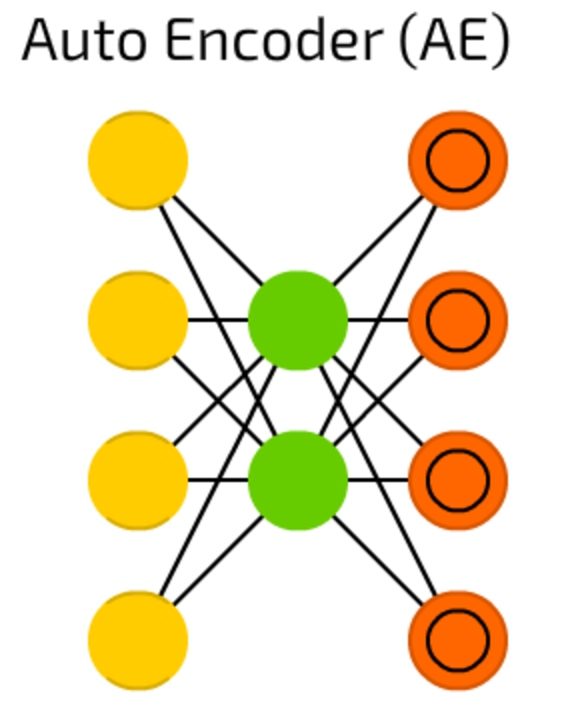

Los codificadores automáticos o autoencoders se utilizan para el preentrenamiento de otras redes, reducción de la dimensionalidad, aprendizaje de espacios latentes, entre otros.

Los autoencoders, por otro lado, pueden ser entrenados sin supervisión. Su estructura generalmente se caracteriza por:
1. La cantidad de neuronas ocultas es menor que la cantidad de celdas de entrada.
2. La cantidad de celdas de salida es igual a la cantidad de celdas de entrada.
3. El autoencoder se entrena de manera en que la salida está lo más cerca posible de la entrada, obligando a los autoencoders a generalizar datos y realizar búsqueda de patrones comunes.

Definimos los parámeteos para la arquitectura de la red:

In [43]:
EPOCHS = 50
BATCH_SIZE = 32
METRICS = ["acc"]
INPUT_DIM = X_new_train.shape[1]
print(INPUT_DIM)

11


In [44]:
autoencoder = Sequential(name="Autoencoder")

#Encoder
autoencoder.add(Input(shape=(INPUT_DIM,))) #Capa de Entrada
#autoencoder.add(Dense(10, activation='relu'))
autoencoder.add(Dense(5, activation='relu'))
#autoencoder.add(Dense(3, activation='relu'))
autoencoder.add(Dense(2, activation='relu'))

#Decoder
#autoencoder.add(Dense(3, activation='relu'))
autoencoder.add(Dense(5, activation='relu'))
#autoencoder.add(Dense(10, activation='relu'))
autoencoder.add(Dense(INPUT_DIM, activation='relu'))

Dejo en los comentarios capas adicionales en el autoencoder, ¿mejoran o empeoran el autoencoder en este contexto?

In [45]:
autoencoder.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=METRICS)
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153 (612.00 B)

 Trainable params: 153 (612.00 B)

 Non-trainable params: 0 (0.00 B)

Una manera más amigable de verlo...

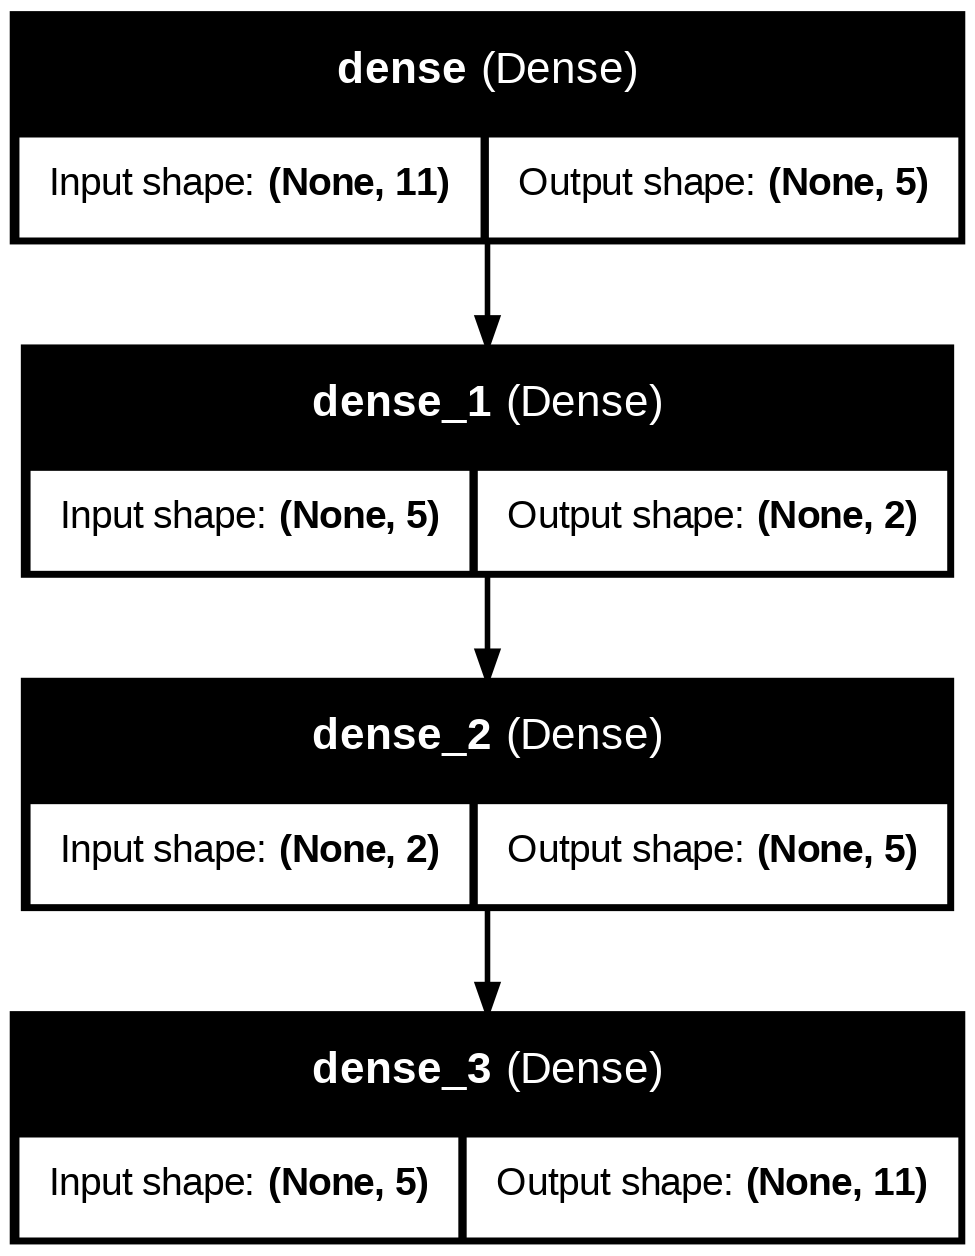

In [46]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

Y utilizaremos un EarlyStopping para evaluar nuestro modelo, por si no encuentra mejora dentro de los entrenamientos de la Red durante las épocas.

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

Definimos el guardado del modelo para reusar en una aplicación o en otro notebook:

##3.4. Entrenamiento

Para detección de anomalías, nuestro input será nuestro conjunto X, y nuestra salida será el mismo conjunto X

In [ ]:
history = autoencoder.fit(X_new_train, X_new_train,
  epochs=EPOCHS,
  shuffle=True,
  batch_size=BATCH_SIZE,
  callbacks=[early_stopping],
  validation_data=(X_new_train, X_new_train)
)

Epoch 1/50
1032/1032 [==============================] - 10s 7ms/step - loss: 0.5090 - acc: 0.5850 - val_loss: 0.4253 - val_acc: 0.7532
Epoch 2/50
1032/1032 [==============================] - 3s 3ms/step - loss: 0.3954 - acc: 0.7076 - val_loss: 0.3796 - val_acc: 0.6862
Epoch 3/50
1032/1032 [==============================] - 3s 3ms/step - loss: 0.3730 - acc: 0.6939 - val_loss: 0.3676 - val_acc: 0.6778
Epoch 4/50
1032/1032 [==============================] - 6s 6ms/step - loss: 0.3630 - acc: 0.7103 - val_loss: 0.3589 - val_acc: 0.7707
Epoch 5/50
1032/1032 [==============================] - 4s 4ms/step - loss: 0.3536 - acc: 0.7825 - val_loss: 0.3494 - val_acc: 0.7781
Epoch 6/50
1032/1032 [==============================] - 3s 3ms/step - loss: 0.3407 - acc: 0.8208 - val_loss: 0.3313 - val_acc: 0.8307
Epoch 7/50
1032/1032 [==============================] - 5s 5ms/step - loss: 0.3272 - acc: 0.8323 - val_loss: 0.3237 - val_acc: 0.8435
Epoch 8/50
1032/1032 [==============================] - 3s 3m

Veamos cómo se comporta la pérdida:

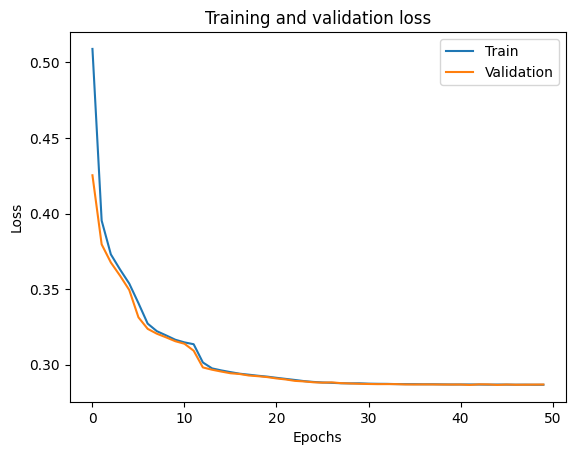

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Y el accuracy:

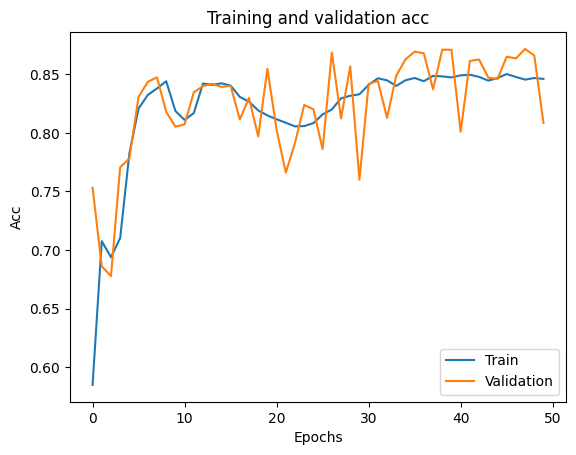

In [ ]:
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Vemos las predicciones

In [ ]:
predicted = autoencoder.predict(X_new_train)
pd.DataFrame(predicted)

1032/1032 [==============================] - 1s 1ms/step


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.000000,0.0,1.229695,0.000000,1.0,1.017988,0.000000,0.0,0.0,0.580899
1,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.083403,0.997040,0.0,0.0,0.519122
2,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.078819,1.001158,0.0,0.0,0.518520
3,0.0,0.000000,0.0,0.992702,0.000000,1.0,0.979739,0.000000,0.0,0.0,0.578394
4,0.0,0.000000,0.0,0.000000,0.292821,1.0,0.180872,0.877350,0.0,0.0,0.526575
...,...,...,...,...,...,...,...,...,...,...,...
33003,0.0,0.000000,0.0,0.564485,0.554066,1.0,0.921425,0.000000,0.0,0.0,0.575315
33004,0.0,3.269111,0.0,2.162477,0.000000,1.0,1.098214,0.000000,0.0,0.0,0.581333
33005,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.812421,0.056492,0.0,0.0,0.567322
33006,0.0,0.000000,0.0,0.000000,0.399215,1.0,0.099433,0.983451,0.0,0.0,0.521362


Calculemos ahora el error en entrenamiento:

In [ ]:
error = tf.keras.losses.mean_squared_error(X_new_train, predicted).numpy()
error

array([0.03097151, 0.21936725, 0.41049767, ..., 0.22558647, 0.07253066,
       0.08802583], dtype=float32)

<ipython-input-59-b826de8b425b>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

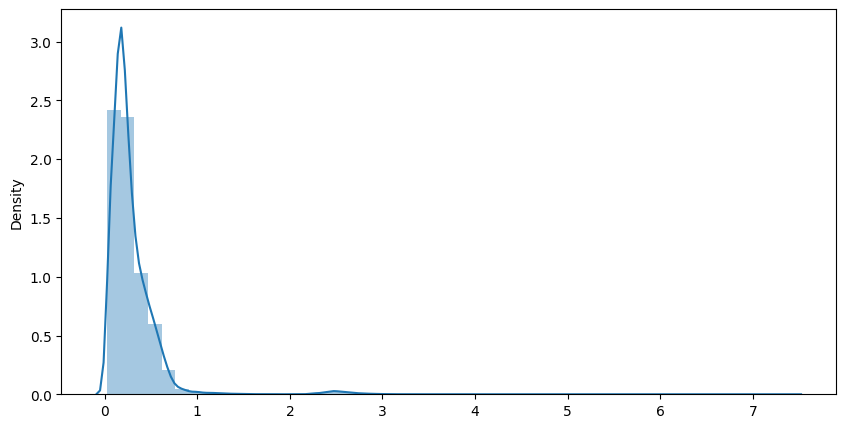

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

sns.distplot(error)

Y establecemos un valor el cual nos dirá que presenta un "comportamiento extraño". En este caso, será el cuantil 99.4, dado que es la proporción entre fraudes y normales en los datos analizados.

2.491848498344421


<ipython-input-60-a71050d87180>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




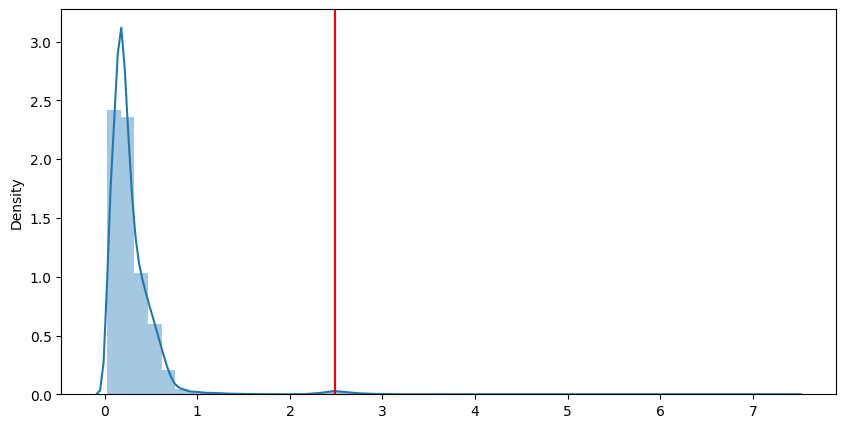

In [ ]:
q = np.quantile(error, (0.994))
print(q)

sns.distplot(error)
plt.axvline(q, 0, 1, color = 'red')
plt.show()

## 3.5. Reconstrucciones.

Debemos procesar los datos de test con los mismos pasos del entrenamiento:

In [ ]:
X_new_test = pipe.fit_transform(X_test)
X_new_test

array([[-0.40861881, -0.32349832, -0.23623115, ...,  0.        ,
         0.        ,  1.        ],
       [-1.28479554, -0.32349832, -0.23623115, ...,  0.        ,
         0.        ,  1.        ],
       [-1.41622205, -0.32349832, -0.23623115, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.12469048, -0.32349832, -0.23623115, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.60658769, -0.32349832, -0.23623115, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.81802863,  3.09120617,  4.23314204, ...,  0.        ,
         1.        ,  0.        ]])

En el paso anterior usamos el pipeline para que los datos de prueba fueran normalizados con los mismos pasos de entrenamiento, ahora lo vamos a pasar por el autoencoder ya entrenado.

In [ ]:
reconstructions = autoencoder.predict(X_new_test)
pd.DataFrame(reconstructions)

280/280 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.000000,0.000000,0.012245,0.551824,1.0,0.832336,0.035872,0.0,0.0,0.569484
1,0.0,0.000000,0.000000,0.016032,0.000000,1.0,0.817729,0.048505,0.0,0.0,0.567484
2,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.086441,0.991126,0.0,0.0,0.518991
3,0.0,0.000000,0.000000,0.026489,0.000000,1.0,0.814539,0.050624,0.0,0.0,0.566941
4,0.0,0.000000,0.000000,0.020004,0.522573,1.0,0.833123,0.034662,0.0,0.0,0.569503
...,...,...,...,...,...,...,...,...,...,...,...
8925,0.0,0.000000,4.879616,0.000000,0.211024,1.0,0.024406,1.079325,0.0,0.0,0.516248
8926,0.0,0.000000,0.000000,0.023376,0.638739,1.0,0.835512,0.032330,0.0,0.0,0.569786
8927,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.102704,0.976472,0.0,0.0,0.521119
8928,0.0,0.000000,0.000000,0.026681,0.000000,1.0,0.823125,0.043037,0.0,0.0,0.568089


Calculemos el error cuadrático medio en las reconstrucciones para cada uno de los pacientes:

In [ ]:
mse = np.mean(np.power(X_new_test - reconstructions, 2), axis=1)

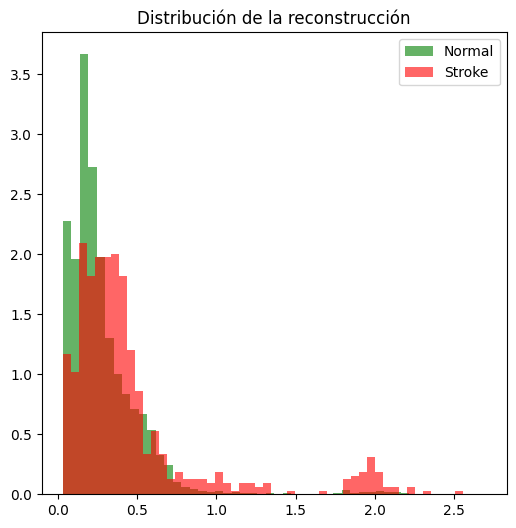

In [ ]:
normal_ = mse[Y_test==0]
stroke_ = mse[Y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_, bins=50, density=True, label="Normal", alpha=.6, color="green")
ax.hist(stroke_, bins=50, density=True, label="Stroke", alpha=.6, color="red")

plt.title("Distribución de la reconstrucción")
plt.legend()
plt.show()

¿Podemos diferenciar la clase normal de los enfermos?, ¿qué opinas?

Obtenemos los nuevos errores de este nuevo conjunto de datos.

In [ ]:
error_test = tf.keras.losses.mean_squared_error(X_new_test, reconstructions).numpy()
error_test

array([0.16397479, 0.29165518, 0.45107573, ..., 0.25036505, 0.32059786,
       1.8591645 ], dtype=float32)

Y vemos el comportamiento utilizando el mismo "punto de corte" que el que establecimos anteriormente.

<ipython-input-66-d2933634543b>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




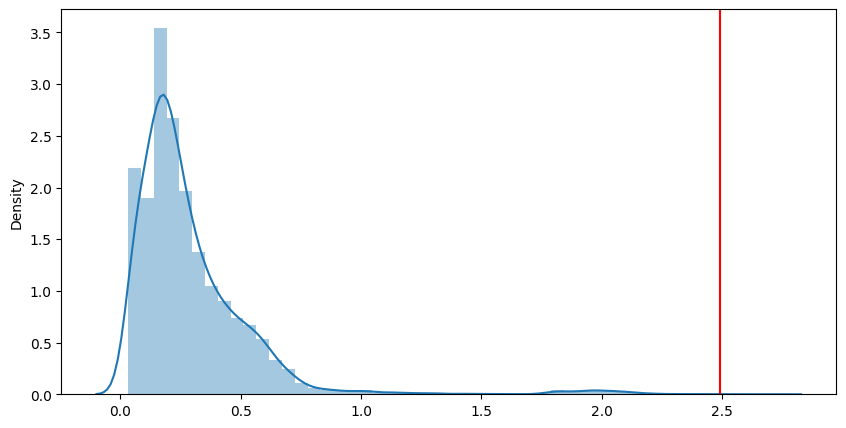

In [ ]:
sns.distplot(error_test)
plt.axvline(q, 0, 1, color = 'red')
plt.show()

## 3.6. Thresholds.

En este caso conocemos las etiquetas, por lo tanto podemos verificar los resultados, usando umbrales.

In [ ]:
y_pred = (error_test > q).astype(int)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print("----- Classification Report for outliers -----")
print(classification_report(Y_test, y_pred))

----- Classification Report for outliers -----
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8287
           1       0.50      0.00      0.00       643

    accuracy                           0.93      8930
   macro avg       0.71      0.50      0.48      8930
weighted avg       0.90      0.93      0.89      8930



¿Y que pasa si movemos nuestro umbral?

2.2820084738731388


<ipython-input-69-acb89b02530e>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




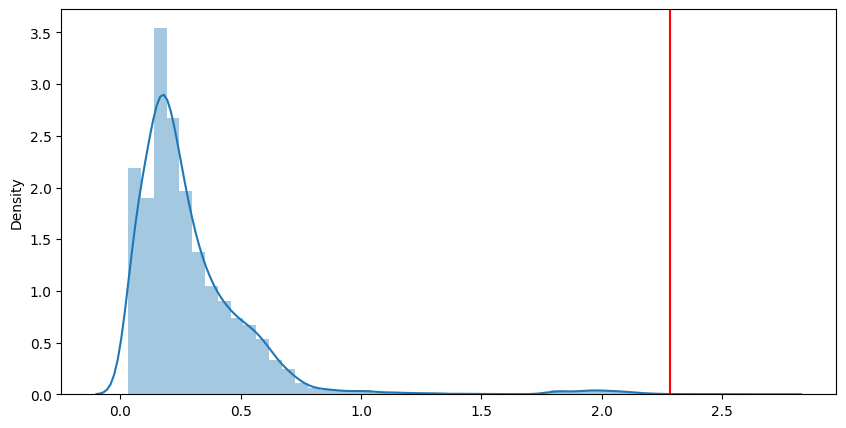

In [ ]:
q = np.quantile(error, (0.99))
print(q)
sns.distplot(error_test, norm_hist=True)
plt.axvline(q, 0, 1, color = 'red')
plt.show()

In [ ]:
q = np.quantile(error, (0.95))
print(q)
y_pred = (error_test > q).astype(int)
y_pred

0.6254544854164118


array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
print("----- Classification Report for outliers -----")
print(classification_report(Y_test, y_pred))

----- Classification Report for outliers -----
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8287
           1       0.19      0.16      0.17       643

    accuracy                           0.89      8930
   macro avg       0.56      0.55      0.56      8930
weighted avg       0.88      0.89      0.89      8930



#4. Preguntas

* ¿Consideras necesario el uso de la variable de fumadores?, ¿mejora el modelo?, ¿Qué decisiones de imputación aplicarías?
* ¿El número de neuronas de las capas influye al aumentar o disminuir en a entrada y la salida?.
* ¿Las funciones de activación las modificarías?, ¿qué aportarían al entrenamiento del autoencoder?.
* ¿Qué ocurriría si adicionas capas al autoencoder?